In [1]:
from scipy.io import loadmat
import numpy as np
from PIL import Image
import glob
from utils import *

## Prepare data

### Gather Data from Structure

In [2]:
mat_files = glob.glob('./dataset/Data/Normalized/**/*.mat', recursive=True)
mat_files.sort()

In [3]:
indices, IMG, POSE, GAZE = gather_data('./dataset/Data/Normalized')

In [4]:
GAZE = gaze3Dto2D(GAZE)
POSE = pose3Dto2D(POSE)

In [5]:
IMG.shape, POSE.shape, GAZE.shape, indices.shape

((213658, 36, 60, 1), (213658, 2), (213658, 2), (213658, 3))

### Check

['p00' 'day01' '0001.jpg']


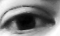

In [6]:
i = 0
print(indices[i])
Image.fromarray(IMG[i].reshape((36, 60)))

## Create NN

In [7]:
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Concatenate, Flatten
from keras.initializers import RandomNormal
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.models import Model

Using TensorFlow backend.


### Layers

In [8]:
# input
input_img = Input(shape=(36, 60, 1), name='InputNormalizedImage')
input_pose = Input(shape=(2,), name='InputHeadPose')

# convolutional
conv1 = Conv2D(filters=20,
               kernel_size=(5, 5),
               strides=(1, 1),
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.1, seed=None),
               bias_initializer='zeros',
               name='conv1'
              )(input_img)
pool1 = MaxPool2D(pool_size=(2, 2),
                  strides=(2, 2),
                  padding='valid',
                  name='maxpool1'
                 )(conv1)
conv2 = Conv2D(filters=50,
               kernel_size=(5, 5),
               strides=(1, 1),
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.01, seed=None),
               bias_initializer='zeros',
               name='conv2'
              )(pool1)
pool2 = MaxPool2D(pool_size=(2, 2),
                  strides=(2, 2),
                  padding='valid',
                  name='maxpool2'
                 )(conv2)

flatt = Flatten(name='flatt')(pool2)

# inner product 1
dense1 = Dense(units=500,
              activation='relu',
              kernel_initializer='glorot_uniform',
              bias_initializer='zeros',
              name='ip1'
             )(flatt)

# concatanate with head pose
cat = Concatenate(axis=-1, name='concat')([dense1, input_pose])

# inner product 2
dense2 = Dense(units=2,
              kernel_initializer='glorot_uniform',
              bias_initializer='zeros',
              name='ip2'
             )(cat)

### Compile

In [9]:
model = Model([input_img, input_pose], dense2)
model.compile(optimizer='adam', loss=euclidean_dist)

### Callback

In [10]:
tbCallBack = TensorBoard(log_dir='./log',
                         histogram_freq=0,
                         write_graph=True,
                         write_images=True)

### Train

In [11]:
model.fit(x=[IMG, POSE], y=GAZE,
          batch_size=1000,
          shuffle=True,
          epochs=3,
          validation_split=0.3,
          callbacks=[tbCallBack])

Train on 149560 samples, validate on 64098 samples
Epoch 1/3
149560/149560 [==============================] - 533s 4ms/step - loss: 2325.2116 - val_loss: 23.0804
Epoch 2/3
149560/149560 [==============================] - 543s 4ms/step - loss: 31.7360 - val_loss: 9.2443
Epoch 3/3
149560/149560 [==============================] - 551s 4ms/step - loss: 4.2522 - val_loss: 6.9708
